# CycleGAN

## Introduction

This notebook demonstrates unpaired image to image translation using conditional GAN's, as described in <a href="https://arxiv.org/pdf/1703.10593.pdf">Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks </a>, also known as CycleGAN. The paper proposes a method that can capture the characteristics of one image domain and figure out how these characteristics could be translated into another image domain, all in the absence of any paired training examples.<br/>
CycleGAN uses a cycle consistency loss to enable training without the need for paired data. In other words, it can translate from one domain to another without a one-to-one mapping between the source and target domain. <br/>
This opens up the possibility to do a lot of interesting tasks like photo-enhancement, image colorization, style transfer, etc. All you need is the source and the target dataset (which is simply a directory of images).

Cycle consistency means the result should be close to the original input. For example, if one translates a sentence from English to French, and then translates it back from French to English, then the resulting sentence should be the same as the original sentence.

In cycle consistency loss,


*   Image $\mathbf{X}$ is passed via generator $\mathbf{G}$ that yields generated image $\hat{\mathbf{Y}}$.
*   Generated image $\hat{\mathbf{Y}}$ is passed via generator $\mathbf{F}$ that yields cycled image $\hat{\mathbf{X}}$.

The process is shown below:


![](https://iili.io/JUHabj.png?style=centerme)


## Implementation

In [1]:
import os
import numpy as np
import math
import itertools
import datetime
import time
import sys

import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchvision.utils import save_image, make_grid

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

from matplotlib import pyplot as plt

import glob
import random
import os

from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.autograd import Variable
import torch
import numpy as np


print('setup done')

setup done


In [0]:
n_epochs = 20
dataset_name = "monet2photo"
batch_size = 8
lr = 0.0002
b1 = 0.5
b2 = 0.999
decay_epoch = 100
img_height = img_width = 140
channels = 3
sample_interval = 100
n_residual_blocks = 9
lambda_cyc = 10.0
lambda_id = 5.0
checkpoint_interval = 3

device = torch.device("cuda:0")

### Creating Dataset

In [3]:
! wget https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/monet2photo.zip

--2020-06-13 10:17:45--  https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/monet2photo.zip
Resolving people.eecs.berkeley.edu (people.eecs.berkeley.edu)... 128.32.189.73
Connecting to people.eecs.berkeley.edu (people.eecs.berkeley.edu)|128.32.189.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 305231073 (291M) [application/zip]
Saving to: ‘monet2photo.zip’

monet2photo.zip     100%[===================>] 291.09M  21.0MB/s    in 15s     

2020-06-13 10:18:01 (19.9 MB/s) - ‘monet2photo.zip’ saved [305231073/305231073]



In [0]:
import zipfile
with zipfile.ZipFile("monet2photo.zip", 'r') as zip_ref:
    zip_ref.extractall("./data")

In [0]:
! rm -rf monet2photo.zip

In [0]:
class ImageDataset(Dataset):
    '''
        creating the dataset class for better performance
    '''
    def __init__(self, root, transforms_=None, unaligned=False, mode="train"):
        self.transform = transforms.Compose(transforms_)
        self.unaligned = unaligned
        self.files_A = sorted(glob.glob(os.path.join(root, "%sA" % mode) + "/*.*"))
        self.files_B = sorted(glob.glob(os.path.join(root, "%sB" % mode) + "/*.*"))

    def __getitem__(self, index):
        image_A = Image.open(self.files_A[index % len(self.files_A)])

        if self.unaligned:
            image_B = Image.open(self.files_B[random.randint(0, len(self.files_B) - 1)])
        else:
            image_B = Image.open(self.files_B[index % len(self.files_B)])

        # Convert grayscale images to rgb
        if image_A.mode != "RGB":
            image_A = ImageDataset.to_rgb(image_A)
        if image_B.mode != "RGB":
            image_B = ImageDataset.to_rgb(image_B)

        item_A = self.transform(image_A)
        item_B = self.transform(image_B)
        return {"A": item_A, "B": item_B}

    def __len__(self):
        return max(len(self.files_A), len(self.files_B))
    
    @staticmethod
    def to_rgb(image):
        rgb_image = Image.new("RGB", image.size)
        rgb_image.paste(image)
        return rgb_image

In [0]:
transforms_ = [
    transforms.Resize(int(img_height * 1.12), Image.BICUBIC),
    transforms.RandomCrop((img_height, img_width)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]

dataloader = DataLoader(
    ImageDataset("./data/monet2photo/", transforms_=transforms_, unaligned=True),
    batch_size=16,
    shuffle=True
)

val_dataloader = DataLoader(
    ImageDataset("./data/monet2photo/", transforms_=transforms_, unaligned=True, mode="test"),
    batch_size=2,
    shuffle=True,
    num_workers=1
)

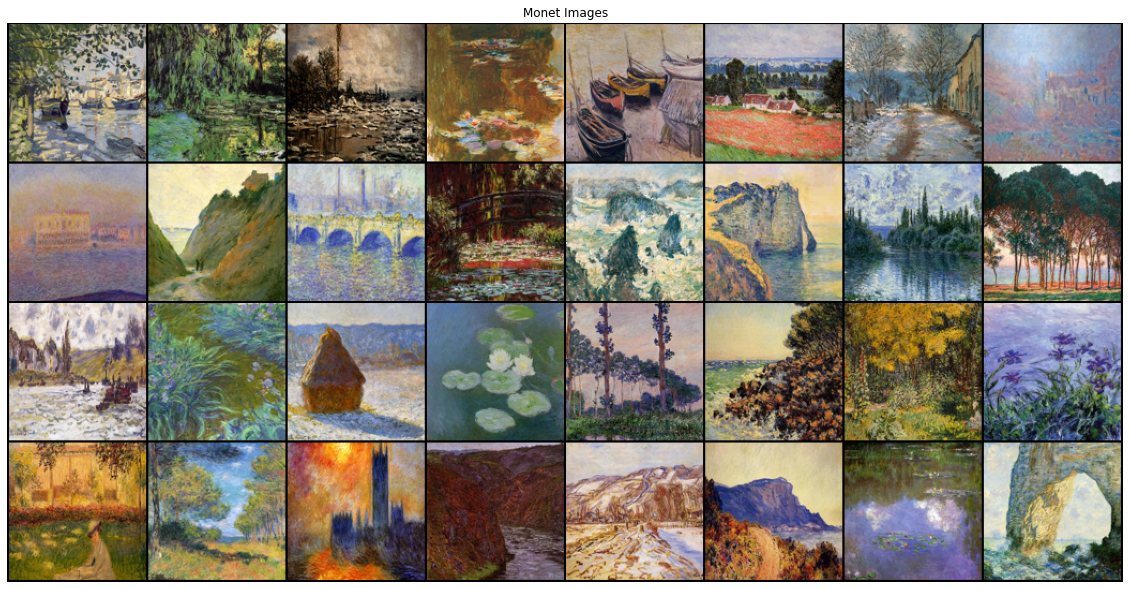

In [0]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(20, 20))
plt.axis("off")
plt.title("Monet Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch['A'].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

### Creating Models

In [0]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
        if hasattr(m, "bias") and m.bias is not None:
            torch.nn.init.constant_(m.bias.data, 0.0)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

In [0]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
        )

    def forward(self, x):
        return x + self.block(x)

In [0]:
class GeneratorResNet(nn.Module):
    def __init__(self, input_shape, num_residual_blocks):
        super(GeneratorResNet, self).__init__()

        channels = input_shape[0]

        # Initial convolution block
        out_features = 64
        model = [
            nn.ReflectionPad2d(channels),
            nn.Conv2d(channels, out_features, 7),
            nn.InstanceNorm2d(out_features),
            nn.ReLU(inplace=True),
        ]
        in_features = out_features

        # Downsampling
        for _ in range(2):
            out_features *= 2
            model += [
                nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True),
            ]
            in_features = out_features

        # Residual blocks
        for _ in range(num_residual_blocks):
            model += [ResidualBlock(out_features)]

        # Upsampling
        for _ in range(2):
            out_features //= 2
            model += [
                nn.Upsample(scale_factor=2),
                nn.Conv2d(in_features, out_features, 3, stride=1, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True),
            ]
            in_features = out_features

        # Output layer
        model += [nn.ReflectionPad2d(channels), nn.Conv2d(out_features, channels, 7), nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

In [0]:
class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()

        channels, height, width = input_shape

        # Calculate output shape of image discriminator (PatchGAN)
        self.output_shape = (1, height // 2 ** 4, width // 2 ** 4)

        def discriminator_block(in_filters, out_filters, normalize=True):
            """Returns downsampling layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(channels, 64, normalize=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 4, padding=1)
        )

    def forward(self, x):
        return self.model(x)

In [27]:
input_shape = (channels, img_height, img_width)

G_AB = GeneratorResNet(input_shape, n_residual_blocks).to(device)
G_BA = GeneratorResNet(input_shape, n_residual_blocks).to(device)
D_A = Discriminator(input_shape).to(device)
D_B = Discriminator(input_shape).to(device)

print(G_AB)
print('--'*30)
print(D_B)

GeneratorResNet(
  (model): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (9): ReLU(inplace=True)
    (10): ResidualBlock(
      (block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (3): ReLU(inplace=True)
        (4): ReflectionPad2d((1, 1, 1, 1))
        

In [28]:
G_AB.apply(weights_init_normal)
G_BA.apply(weights_init_normal)
D_A.apply(weights_init_normal)
D_B.apply(weights_init_normal)

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): ZeroPad2d(padding=(1, 0, 1, 0), value=0.0)
    (12): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  )
)

### Training

In [0]:
class LambdaLR:
    def __init__(self, n_epochs, offset, decay_start_epoch):
        self.n_epochs = n_epochs
        self.offset = offset
        self.decay_start_epoch = decay_start_epoch

    def step(self, epoch):
        return 1.0 - max(0, epoch + self.offset - self.decay_start_epoch) / (self.n_epochs - self.decay_start_epoch)

In [0]:
class ReplayBuffer:
    def __init__(self, max_size=50):
        self.max_size = max_size
        self.data = []

    def push_and_pop(self, data):
        to_return = []
        for element in data.data:
            element = torch.unsqueeze(element, 0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                to_return.append(element)
            else:
                if random.uniform(0, 1) > 0.5:
                    i = random.randint(0, self.max_size - 1)
                    to_return.append(self.data[i].clone())
                    self.data[i] = element
                else:
                    to_return.append(element)
        return Variable(torch.cat(to_return))

In [0]:
optimizer_G = torch.optim.Adam(
    itertools.chain(G_AB.parameters(), G_BA.parameters()), lr=lr, betas=(b1, b2)
)
optimizer_D_A = torch.optim.Adam(D_A.parameters(), lr=lr, betas=(b1, b2))
optimizer_D_B = torch.optim.Adam(D_B.parameters(), lr=lr, betas=(b1, b2))

lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(
    optimizer_G, lr_lambda=LambdaLR(n_epochs, 0, decay_epoch).step
)
lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(
    optimizer_D_A, lr_lambda=LambdaLR(n_epochs, 0, decay_epoch).step
)
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(
    optimizer_D_B, lr_lambda=LambdaLR(n_epochs, 0, decay_epoch).step
)

In [0]:
Tensor = torch.cuda.FloatTensor

fake_A_buffer = ReplayBuffer()
fake_B_buffer = ReplayBuffer()

In [0]:
def sample_images(batches_done):
    """Saves a generated sample from the test set"""
    imgs = next(iter(val_dataloader))
    G_AB.eval()
    G_BA.eval()
    real_A = Variable(imgs["A"].type(Tensor))
    fake_B = G_AB(real_A)
    real_B = Variable(imgs["B"].type(Tensor))
    fake_A = G_BA(real_B)

    real_A = make_grid(real_A, nrow=5, normalize=True)
    real_B = make_grid(real_B, nrow=5, normalize=True)
    fake_A = make_grid(fake_A, nrow=5, normalize=True)
    fake_B = make_grid(fake_B, nrow=5, normalize=True)

    image_grid = torch.cat((real_A, fake_B, real_B, fake_A), 1)
    save_image(image_grid, "images/monet/%s.png" % (batches_done), normalize=False)

In [34]:
! mkdir ./images
! mkdir ./images/monet
! mkdir ./saved_models/
! mkdir ./saved_models/monet

mkdir: cannot create directory ‘./images’: File exists
mkdir: cannot create directory ‘./images/monet’: File exists
mkdir: cannot create directory ‘./saved_models/’: File exists
mkdir: cannot create directory ‘./saved_models/monet’: File exists


In [35]:
prev_time = time.time()

criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()

for epoch in range(n_epochs):
    for i, batch in enumerate(dataloader):

        real_A = Variable(batch["A"].type(Tensor))
        real_B = Variable(batch["B"].type(Tensor))

        # Adversarial ground truths
        valid = Variable(Tensor(np.ones((real_A.size(0), *D_A.output_shape))), requires_grad=False)
        fake = Variable(Tensor(np.zeros((real_A.size(0), *D_A.output_shape))), requires_grad=False)

        # ------------------
        #  Train Generators
        # ------------------

        G_AB.train()
        G_BA.train()

        optimizer_G.zero_grad()

        loss_id_A = criterion_identity(G_BA(real_A), real_A)
        loss_id_B = criterion_identity(G_AB(real_B), real_B)

        loss_identity = (loss_id_A + loss_id_B) / 2

        # GAN loss
        fake_B = G_AB(real_A)
        loss_GAN_AB = criterion_GAN(D_B(fake_B), valid)
        fake_A = G_BA(real_B)
        loss_GAN_BA = criterion_GAN(D_A(fake_A), valid)

        loss_GAN = (loss_GAN_AB + loss_GAN_BA) / 2

        # Cycle loss
        recov_A = G_BA(fake_B)
        loss_cycle_A = criterion_cycle(recov_A, real_A)
        recov_B = G_AB(fake_A)
        loss_cycle_B = criterion_cycle(recov_B, real_B)

        loss_cycle = (loss_cycle_A + loss_cycle_B) / 2

        # Total loss
        loss_G = loss_GAN + lambda_cyc * loss_cycle + lambda_id * loss_identity

        loss_G.backward()
        optimizer_G.step()

        # -----------------------
        #  Train Discriminator A
        # -----------------------

        optimizer_D_A.zero_grad()

        # Real loss
        loss_real = criterion_GAN(D_A(real_A), valid)
        # Fake loss (on batch of previously generated samples)
        fake_A_ = fake_A_buffer.push_and_pop(fake_A)
        loss_fake = criterion_GAN(D_A(fake_A_.detach()), fake)
        # Total loss
        loss_D_A = (loss_real + loss_fake) / 2

        loss_D_A.backward()
        optimizer_D_A.step()

        # -----------------------
        #  Train Discriminator B
        # -----------------------

        optimizer_D_B.zero_grad()

        # Real loss
        loss_real = criterion_GAN(D_B(real_B), valid)
        # Fake loss (on batch of previously generated samples)
        fake_B_ = fake_B_buffer.push_and_pop(fake_B)
        loss_fake = criterion_GAN(D_B(fake_B_.detach()), fake)
        # Total loss
        loss_D_B = (loss_real + loss_fake) / 2

        loss_D_B.backward()
        optimizer_D_B.step()

        loss_D = (loss_D_A + loss_D_B) / 2

        # --------------
        #  Log Progress
        # --------------

        # Determine approximate time left
        batches_done = epoch * len(dataloader) + i
        batches_left = n_epochs * len(dataloader) - batches_done
        time_left = datetime.timedelta(seconds=batches_left * (time.time() - prev_time))
        prev_time = time.time()

        if i % 200 == 0:
            print(
                "\r[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f, adv: %f, cycle: %f, identity: %f] ETA: %s"
                % (
                    epoch,
                    n_epochs,
                    i,
                    len(dataloader),
                    loss_D.item(),
                    loss_G.item(),
                    loss_GAN.item(),
                    loss_cycle.item(),
                    loss_identity.item(),
                    time_left,
                )
            )

        # If at sample interval save image
        if batches_done % sample_interval == 0:
            sample_images(batches_done)

    # Update learning rates
    lr_scheduler_G.step()
    lr_scheduler_D_A.step()
    lr_scheduler_D_B.step()

    if checkpoint_interval != -1 and epoch % checkpoint_interval == 0:
        # Save model checkpoints
        torch.save(G_AB.state_dict(), "saved_models/monet/G_AB_%d.pth" % (epoch))
        torch.save(G_BA.state_dict(), "saved_models/monet/G_BA_%d.pth" % (epoch))
        torch.save(D_A.state_dict(), "saved_models/monet/D_A_%d.pth" % (epoch))
        torch.save(D_B.state_dict(), "saved_models/monet/D_B_%d.pth" % (epoch))

[Epoch 0/20] [Batch 0/393] [D loss: 2.261123] [G loss: 12.331038, adv: 2.946524, cycle: 0.626199, identity: 0.624505] ETA: 2:55:08.824782
[Epoch 0/20] [Batch 200/393] [D loss: 0.197868] [G loss: 5.203292, adv: 0.471380, cycle: 0.336303, identity: 0.273777] ETA: 2:27:18.376546
[Epoch 1/20] [Batch 0/393] [D loss: 0.211810] [G loss: 3.458359, adv: 0.497585, cycle: 0.201001, identity: 0.190153] ETA: 2:49:51.223123
[Epoch 1/20] [Batch 200/393] [D loss: 0.177631] [G loss: 3.771797, adv: 0.511451, cycle: 0.219759, identity: 0.212550] ETA: 2:20:03.946647
[Epoch 2/20] [Batch 0/393] [D loss: 0.152388] [G loss: 3.819916, adv: 0.668568, cycle: 0.216231, identity: 0.197807] ETA: 2:15:55.838777
[Epoch 2/20] [Batch 200/393] [D loss: 0.155112] [G loss: 3.465252, adv: 0.358320, cycle: 0.206021, identity: 0.209345] ETA: 2:11:55.024130
[Epoch 3/20] [Batch 0/393] [D loss: 0.183175] [G loss: 3.902381, adv: 0.730961, cycle: 0.214535, identity: 0.205214] ETA: 2:09:02.276547
[Epoch 3/20] [Batch 200/393] [D lo

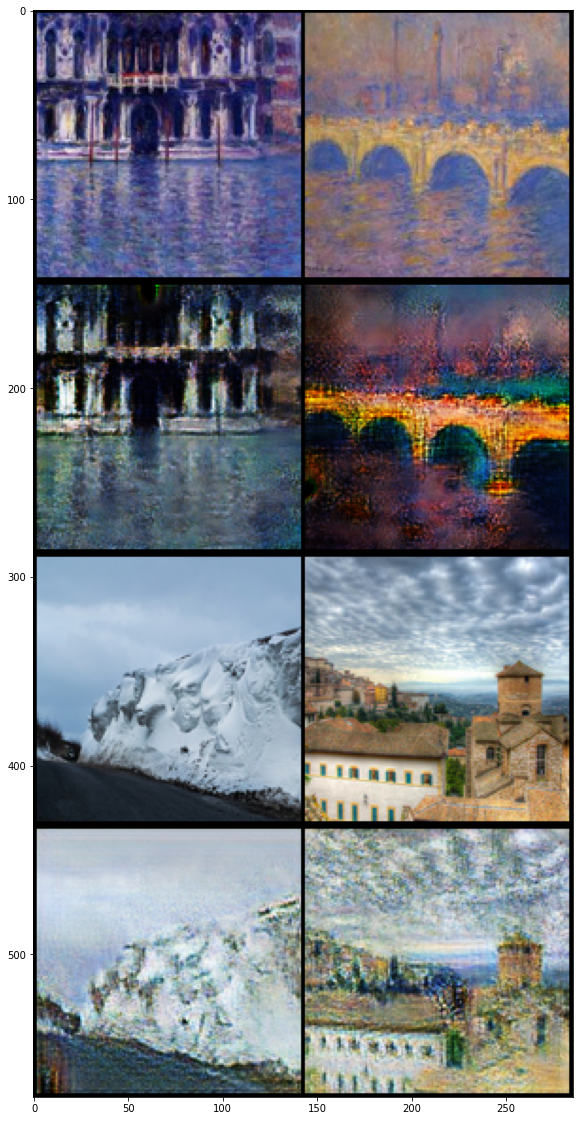

In [0]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython import display
import time


PATH = "./images/monet/{:d}.png"

%matplotlib inline

for i in range(6000, 7900, 100):
    plt.figure(figsize=(20, 20))
    p = PATH.format(i)
    image = mpimg.imread(p) # images are color images
    plt.gca().clear()
    plt.imshow(image);
    display.display(plt.gcf())
    display.clear_output(wait=True)
    time.sleep(1.0) # wait one second